<a href="https://colab.research.google.com/github/Mo-kw/cifar10-image-classification-tensorflow/blob/main/Image_Classification_on_CIFAR_100_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install required packages and import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np


In [3]:
# Load CIFAR-10 dataset and prepare generators with resizing
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=32, shuffle=True)
test_generator = test_datagen.flow(x_test, y_test, batch_size=32)



In [4]:
# Use tf.data to resize images dynamically
def resize_gen(generator):
    for batch_x, batch_y in generator:
        batch_x = tf.image.resize(batch_x, (224, 224))
        batch_y = tf.keras.utils.to_categorical(batch_y, 10)
        yield batch_x, batch_y

train_resized = tf.data.Dataset.from_generator(
    lambda: resize_gen(train_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 10), dtype=tf.float32))
).prefetch(1)

test_resized = tf.data.Dataset.from_generator(
    lambda: resize_gen(test_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 10), dtype=tf.float32))
).prefetch(1)



In [5]:
base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 4 conv layers before building the model
for layer in base.layers[:-4]:
    layer.trainable = False
for layer in base.layers[-4:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)
model = Model(inputs=base.input, outputs=output)




In [6]:
# Compile the model
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



In [6]:
# Train the model using resized data generator
model.fit(train_resized, epochs=10, steps_per_epoch=len(train_generator), validation_data=test_resized, validation_steps=len(test_generator))



Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 398s 245ms/step - accuracy: 0.5086 - loss: 1.3641 - val_accuracy: 0.7502 - val_loss: 0.7084
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 380s 243ms/step - accuracy: 0.7746 - loss: 0.6553 - val_accuracy: 0.7998 - val_loss: 0.5813
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 377s 241ms/step - accuracy: 0.8357 - loss: 0.4853 - val_accuracy: 0.8157 - val_loss: 0.5461
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 383s 245ms/step - accuracy: 0.8754 - loss: 0.3670 - val_accuracy: 0.8482 - val_loss: 0.4348
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 382s 244ms/step - accuracy: 0.9014 - loss: 0.2926 - val_accuracy: 0.8469 - val_loss: 0.4596
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 372s 238ms/step - accuracy: 0.9260 - loss: 0.2187 - val_accuracy: 0.8446 - val_loss: 0.4718
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 382s 245ms/step - accuracy: 0.9402 - loss: 0.1709 - val_accuracy: 0.8548 - val_loss: 0.4738
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 371s 237ms/step - ac

In [11]:
# Save the trained model to a file
model.save('cifar10_model.h5')


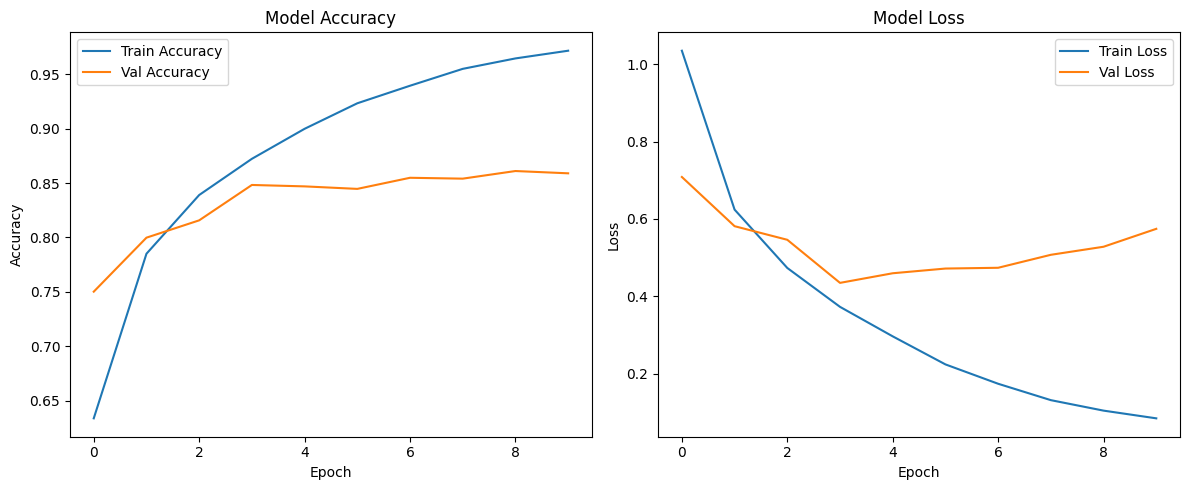

In [8]:
# Plot training and validation accuracy and loss
import matplotlib.pyplot as plt

history_dict = model.history.history

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


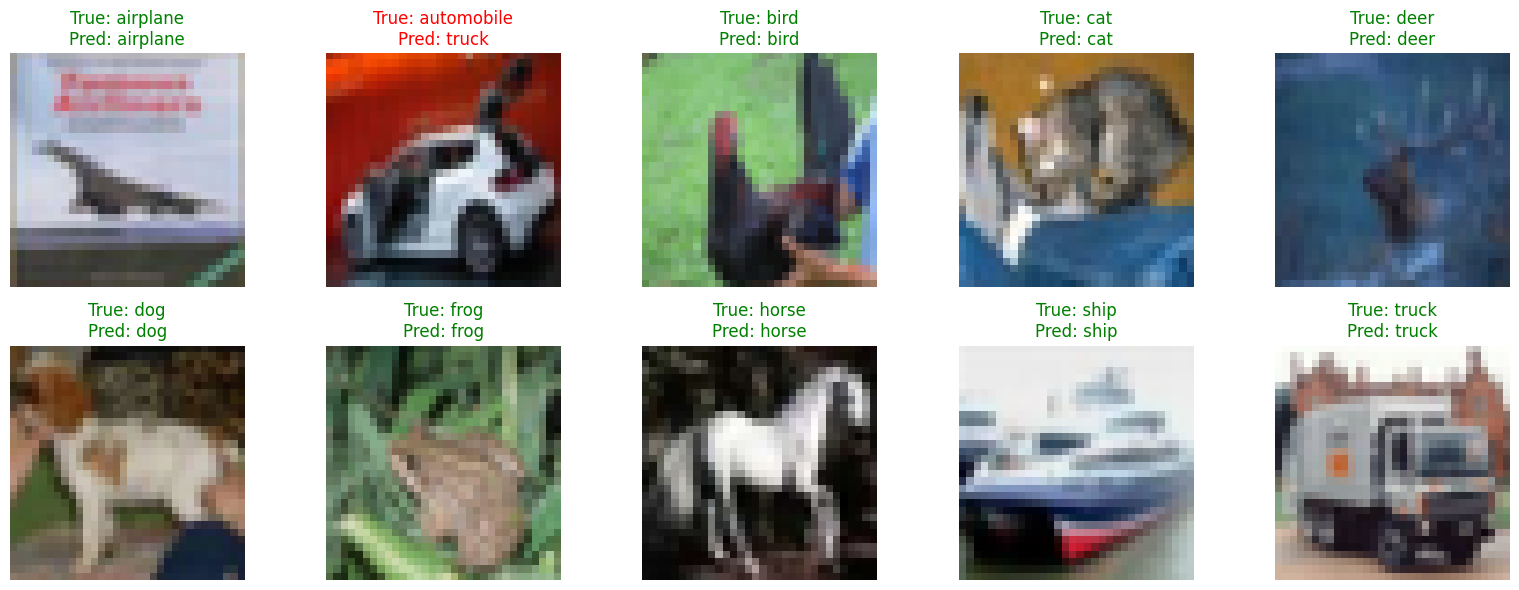

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Load CIFAR-10 test data
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Select 1 image per class
selected_idxs = []
for class_id in range(10):
    for idx in range(len(y_test)):
        if y_test[idx][0] == class_id:
            selected_idxs.append(idx)
            break

plt.figure(figsize=(16, 6))

for i, idx in enumerate(selected_idxs):
    img = x_test[idx]

    # Prepare input for model
    input_img = tf.image.resize(img, (224, 224)) / 255.0
    input_img = tf.expand_dims(input_img, axis=0)

    # Prediction
    prediction = model.predict(input_img, verbose=0)
    pred_class = np.argmax(prediction)
    true_class = y_test[idx][0]

    pred_name = class_names[pred_class]
    true_name = class_names[true_class]
    correct = pred_class == true_class

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"True: {true_name}\nPred: {pred_name}",
        color='green' if correct else 'red',
        fontsize=12
    )

plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

    airplane     0.8367    0.9220    0.8773      1000
  automobile     0.9178    0.9490    0.9331      1000
        bird     0.8066    0.8550    0.8301      1000
         cat     0.8282    0.6220    0.7105      1000
        deer     0.7415    0.9210    0.8216      1000
         dog     0.7724    0.8010    0.7865      1000
        frog     0.9286    0.8710    0.8989      1000
       horse     0.8937    0.8740    0.8837      1000
        ship     0.9499    0.8920    0.9201      1000
       truck     0.9521    0.8750    0.9119      1000

    accuracy                         0.8582     10000
   macro avg     0.8628    0.8582    0.8574     10000
weighted avg     0.8628    0.8582    0.8574     10000



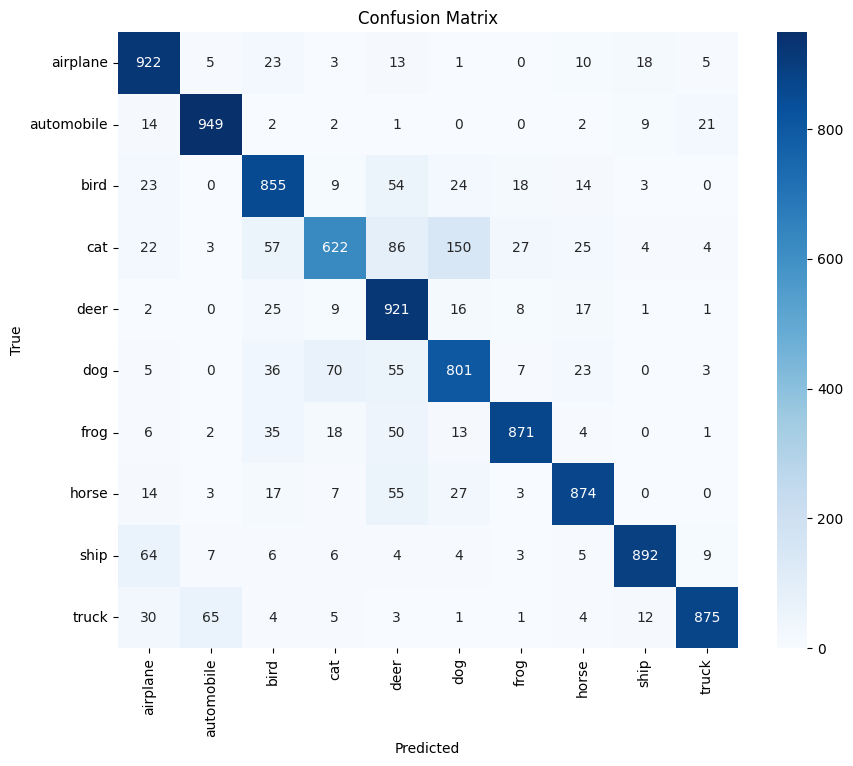

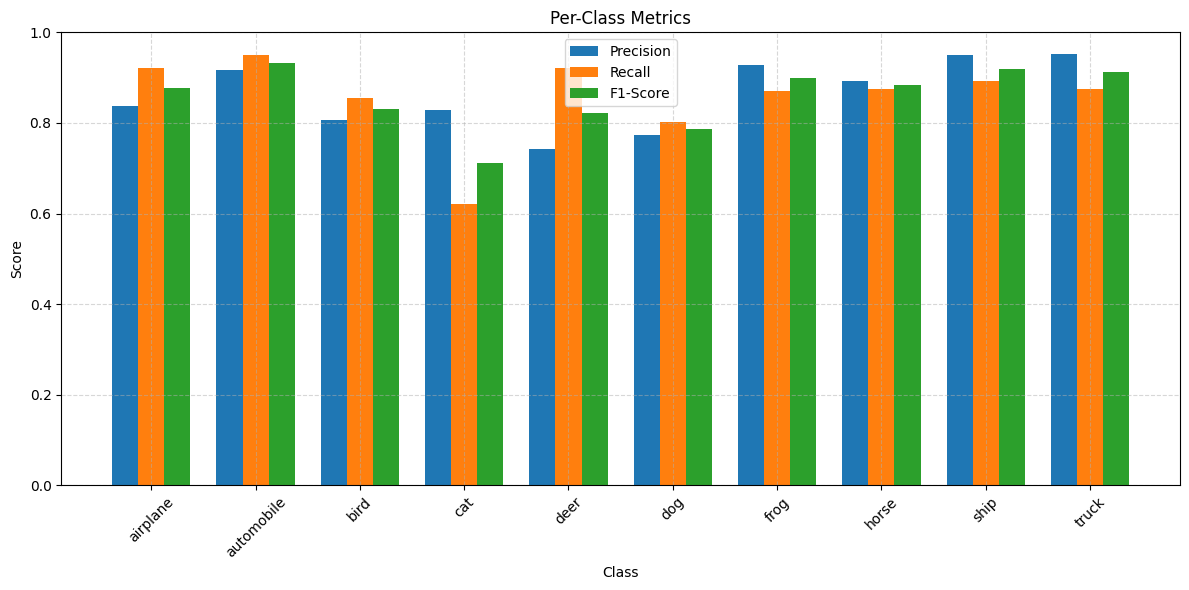

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Load saved model
model = tf.keras.models.load_model('cifar10_model.h5')

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Load CIFAR-10 test set
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize
x_test = x_test.astype('float32') / 255.0
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

# Create batched, resized tf.data.Dataset
batch_size = 32
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, [224, 224]), y))
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Get true and predicted labels
true_labels = []
pred_labels = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    pred_labels.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(labels.numpy(), axis=1))

# Classification report
report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True, digits=4)
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# --- Plot 1: Confusion Matrix Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Plot 2: Per-Class Metrics ---
precision = [report[c]['precision'] for c in class_names]
recall = [report[c]['recall'] for c in class_names]
f1 = [report[c]['f1-score'] for c in class_names]
x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision, width=width, label='Precision')
plt.bar(x, recall, width=width, label='Recall')
plt.bar(x + width, f1, width=width, label='F1-Score')
plt.xticks(x, class_names, rotation=45)
plt.ylim(0, 1)
plt.title("Per-Class Metrics")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
